In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/rapget-translation


In [18]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/rapget-translation/.env


True

In [19]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("DATA_PATH")
results_path = os.getenv("RESULTS_PATH")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(model_name, adapter_name_or_path, load_in_4bit, data_path, results_path, use_english_datasets, max_new_tokens)

Qwen/Qwen2-7B-Instruct None False datasets/mac/mac.tsv results/mac-results.csv False 300


In [20]:
%%time
os.environ["TOKENIZERS_PARALLELISM"] = "true"

!python --version
!pip show torch transformers

Python 3.11.9
Name: torch
Version: 2.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, peft, torchaudio, torchvision
---
Name: transformers
Version: 4.43.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenize

In [21]:
from llm_toolkit.llm_utils import *
from llm_toolkit.translation_utils import *

device = check_gpu()

MPS is available


In [22]:
import pandas as pd

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 58 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   chinese                                             1133 non-null   object
 1   english                                             1133 non-null   object
 2   Qwen/Qwen2-7B-Instruct/rpp-1.00                     1133 non-null   object
 3   Qwen/Qwen2-7B-Instruct/rpp-1.02                     1133 non-null   object
 4   Qwen/Qwen2-7B-Instruct/rpp-1.04                     1133 non-null   object
 5   Qwen/Qwen2-7B-Instruct/rpp-1.06                     1133 non-null   object
 6   Qwen/Qwen2-7B-Instruct/rpp-1.08                     1133 non-null   object
 7   Qwen/Qwen2-7B-Instruct/rpp-1.10                     1133 non-null   object
 8   Qwen/Qwen2-72B-Instruct/rpp-1.00                    1133 non-null   object
 9   Qwen/Qwe

In [23]:
columns = df.columns[2:].to_list()
columns.sort()
columns = df.columns[:2].to_list() + columns
columns

['chinese',
 'english',
 'Qwen/Qwen2-72B-Instruct/rpp-1.00',
 'Qwen/Qwen2-72B-Instruct/rpp-1.02',
 'Qwen/Qwen2-72B-Instruct/rpp-1.04',
 'Qwen/Qwen2-72B-Instruct/rpp-1.06',
 'Qwen/Qwen2-72B-Instruct/rpp-1.08',
 'Qwen/Qwen2-72B-Instruct/rpp-1.10',
 'Qwen/Qwen2-72B-Instruct/rpp-1.12',
 'Qwen/Qwen2-7B-Instruct/rpp-1.00',
 'Qwen/Qwen2-7B-Instruct/rpp-1.02',
 'Qwen/Qwen2-7B-Instruct/rpp-1.04',
 'Qwen/Qwen2-7B-Instruct/rpp-1.06',
 'Qwen/Qwen2-7B-Instruct/rpp-1.08',
 'Qwen/Qwen2-7B-Instruct/rpp-1.10',
 'Qwen/Qwen2-7B-Instruct/rpp-1.12',
 'Qwen/Qwen2-7B-Instruct/rpp-1.14',
 'Qwen/Qwen2-7B-Instruct/rpp-1.16',
 'Qwen/Qwen2-7B-Instruct/rpp-1.18',
 'Qwen/Qwen2-7B-Instruct/rpp-1.20',
 'Qwen/Qwen2-7B-Instruct/rpp-1.22',
 'Qwen/Qwen2-7B-Instruct/rpp-1.24',
 'Qwen/Qwen2-7B-Instruct/rpp-1.26',
 'Qwen/Qwen2-7B-Instruct/rpp-1.28',
 'Qwen/Qwen2-7B-Instruct/rpp-1.30',
 'internlm/internlm2_5-7b-chat/rpp-1.00',
 'shenzhi-wang/Llama3.1-8B-Chinese-Chat/rpp-1.00',
 'shenzhi-wang/Llama3.1-8B-Chinese-Chat/rpp-1.02

In [24]:
df = df[columns]

In [25]:
metrics_df = get_metrics(df, max_new_tokens=max_new_tokens)
metrics_df

TypeError: get_metrics() got an unexpected keyword argument 'max_new_tokens'

In [ ]:
metrics_df["rap"] = metrics_df.apply(
    lambda x: x["meteor"] / math.log10(10 + x["total_repetitions"]), axis=1
)

In [ ]:
metrics_df

model   rpp    meteor    bleu_1  \
0                     Qwen/Qwen2-72B-Instruct  1.00  0.393169  0.122732   
1                     Qwen/Qwen2-72B-Instruct  1.02  0.392567  0.124211   
2                     Qwen/Qwen2-72B-Instruct  1.04  0.392359  0.124027   
3                     Qwen/Qwen2-72B-Instruct  1.06  0.390993  0.123245   
4                     Qwen/Qwen2-72B-Instruct  1.08  0.391984  0.122016   
5                     Qwen/Qwen2-72B-Instruct  1.10  0.391010  0.120610   
6                     Qwen/Qwen2-72B-Instruct  1.12  0.389989  0.118383   
7                      Qwen/Qwen2-7B-Instruct  1.00  0.377314  0.117482   
8                      Qwen/Qwen2-7B-Instruct  1.02  0.377679  0.116432   
9                      Qwen/Qwen2-7B-Instruct  1.04  0.377817  0.115458   
10                     Qwen/Qwen2-7B-Instruct  1.06  0.377353  0.115099   
11                     Qwen/Qwen2-7B-Instruct  1.08  0.374707  0.111649   
12                     Qwen/Qwen2-7B-Instruct  1.10  0.372693  0.109254   
13                     Qwen/Qwen2-7B-Instruct  1.12  0.370982  0.106475   
14                     Qwen/Qwen2-7B-Instruct  1.14  0.368016  0.104374   
15                     Qwen/Qwen2-7B-Instruct  1.16  0.367392  0.102063   
16                     Qwen/Qwen2-7B-Instruct  1.18  0.363967  0.098785   
17                     Qwen/Qwen2-7B-Instruct  1.20  0.359735  0.095148   
18                     Qwen/Qwen2-7B-Instruct  1.22  0.357408  0.091995   
19                     Qwen/Qwen2-7B-Instruct  1.24  0.353440  0.086439   
20                     Qwen/Qwen2-7B-Instruct  1.26  0.347960  0.081427   
21                     Qwen/Qwen2-7B-Instruct  1.28  0.343811  0.073416   
22                     Qwen/Qwen2-7B-Instruct  1.30  0.340523  0.072306   
23      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.00  0.357698  0.101524   
24      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.02  0.358107  0.101070   
25      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.04  0.356593  0.100771   
26      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.06  0.356111  0.099382   
27      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.08  0.354627  0.096925   
28      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.10  0.352866  0.096716   
29      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.12  0.351496  0.094758   
30      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.14  0.352047  0.094639   
31      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.16  0.350526  0.093526   
32      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.18  0.348900  0.092894   
33      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.20  0.347743  0.091333   
34      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.22  0.346087  0.090244   
35      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.24  0.344097  0.083233   
36      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.26  0.342644  0.085137   
37      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.28  0.340342  0.083787   
38      shenzhi-wang/Llama3.1-8B-Chinese-Chat  1.30  0.339350  0.081988   
39  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.00  0.325602  0.083401   
40  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.02  0.325564  0.083978   
41  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.04  0.325920  0.080849   
42  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.06  0.325645  0.081127   
43  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.08  0.325542  0.081767   
44  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.10  0.325969  0.085563   
45  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.12  0.324518  0.085272   
46  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.14  0.322710  0.084580   
47  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.16  0.322690  0.083260   
48  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.18  0.321639  0.081791   
49  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.20  0.320616  0.080396   
50  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.22  0.319095  0.079396   
51  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.24  0.318944  0.079632   
52  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  1.26  0.317910  0.

In [ ]:
models = metrics_df["model"].unique()

In [ ]:
models

array(['Qwen/Qwen2-72B-Instruct', 'Qwen/Qwen2-7B-Instruct',
       'shenzhi-wang/Llama3.1-8B-Chinese-Chat',
       'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat'], dtype=object)

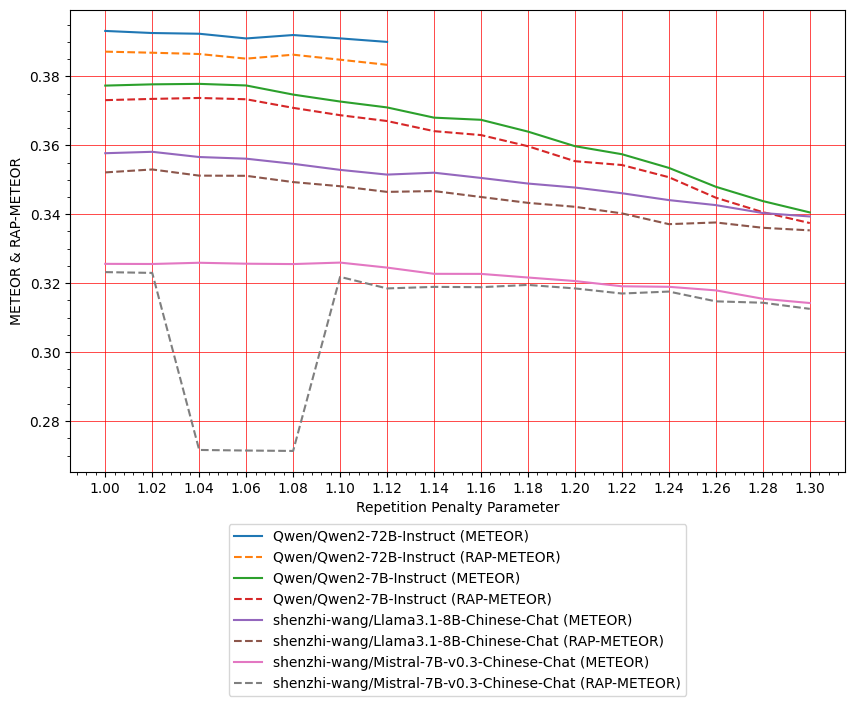

In [ ]:
# plot meteor vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(model_df["rpp"], model_df["meteor"], label=model + " (METEOR)")
    ax.plot(
        model_df["rpp"], model_df["rap"], label=model + " (RAP-METEOR)", linestyle="--"
    )

ax.set_xlabel("Repetition Penalty Parameter")
ax.set_ylabel("METEOR & RAP-METEOR")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
plt.show()

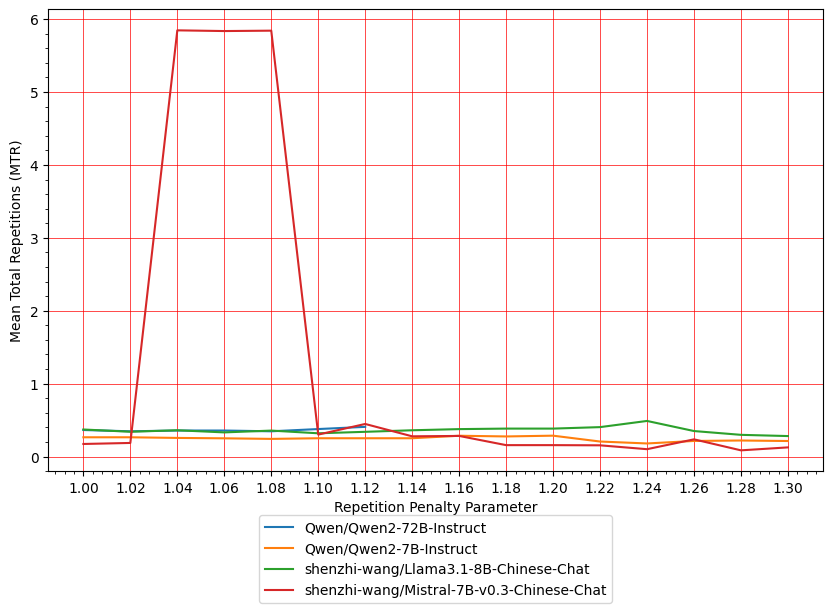

In [ ]:
# plot mtr vs rpp
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# set grid
ax.grid(True)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")
# ax.grid(which="minor", linestyle=":", linewidth="0.5", color="black")

for model in models:
    model_df = metrics_df[metrics_df["model"] == model]
    ax.plot(model_df["rpp"], model_df["total_repetitions"], label=model)


ax.set_xlabel("Repetition Penalty Parameter")
ax.set_ylabel("Mean Total Repetitions (MTR)")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

In [ ]:
tokenizers = {model: load_tokenizer(model) for model in models}

In [ ]:
col = "shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.04"
df[["ews_score", "repetition_score", "total_repetitions"]] = df[col].apply(
    detect_scores
)
df["output_tokens"] = df[col].apply(
    lambda x: len(tokenizers[col.split("/rpp")[0]](x)["input_ids"])
)

In [ ]:
rows = df.query("total_repetitions > 1000")
rows

chinese                                 english  \
193  “有…… 没有…… 有…… 没有……  'Yes . . . no . . . yes . . . no . . .   

                      Qwen/Qwen2-72B-Instruct/rpp-1.00  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.02  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.04  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.06  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.08  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.10  \
193  "There is... There isn't... There is... There ...   

                      Qwen/Qwen2-72B-Instruct/rpp-1.12  \
193  "There is... There isn't... There is... There ...   

    Qwen/Qwen2-7B-Instruct/rpp-1.00  ...  \
193     "Yes... No... Yes... No..."  ...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.20  \
193                          Yes... No... Yes... No...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.22  \
193                          Yes... No... Yes... No...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.24  \
193                          Yes... No... Yes... No...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.26  \
193                          Yes... No... Yes... No...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.28  \
193                          Yes... No... Yes... No...   

    shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/rpp-1.30 ews_score  \
193                          Yes... No... Yes... No...         0   

    repetition_score total_repetitions output_tokens  
193             6496              6496          2049  

[1 rows x 61 columns]

In [ ]:
row = rows.iloc[0]

In [ ]:
print(row["chinese"])

“有…… 没有…… 有…… 没有……


In [ ]:
print(row["english"])

'Yes . . . no . . . yes . . . no . . .


In [ ]:
output = row[col]
print(output)
detect_repetitions(output, debug=True)

Yes, I can help you with that! Here's the translation:

"Yes, I can help you with that! Here's the translation:

有 - Yes
没有 - No

So, the translated content is:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

Yes, I can help you with that! Here's the translation:

(0, 6496, 6496)

In [ ]:
for model in models:
    df[f"ground_truth_tokens-{model}"] = df["english"].apply(
        lambda x: len(tokenizers[model](x)["input_ids"])
    )

df.describe()

ews_score  repetition_score  total_repetitions  output_tokens  \
count     1133.0       1133.000000        1133.000000    1133.000000   
mean         0.0          5.846425           5.846425      33.958517   
std          0.0        192.990061         192.990061      63.822891   
min          0.0          0.000000           0.000000       3.000000   
25%          0.0          0.000000           0.000000      17.000000   
50%          0.0          0.000000           0.000000      27.000000   
75%          0.0          0.000000           0.000000      42.000000   
max          0.0       6496.000000        6496.000000    2049.000000   

       ground_truth_tokens-Qwen/Qwen2-72B-Instruct  \
count                                  1133.000000   
mean                                     29.458076   
std                                      20.126659   
min                                       1.000000   
25%                                      16.000000   
50%                                      25.000000   
75%                                      38.000000   
max                                     135.000000   

       ground_truth_tokens-Qwen/Qwen2-7B-Instruct  \
count                                 1133.000000   
mean                                    29.458076   
std                                     20.126659   
min                                      1.000000   
25%                                     16.000000   
50%                                     25.000000   
75%                                     38.000000   
max                                    135.000000   

       ground_truth_tokens-shenzhi-wang/Llama3.1-8B-Chinese-Chat  \
count                                        1133.000000           
mean                                           29.432480           
std                                            20.076666           
min                                             1.000000           
25%                                            16.000000           
50%                                            25.000000           
75%                                            38.000000           
max                                           135.000000           

       ground_truth_tokens-shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat  
count                                        1133.000000              
mean                                           32.805825              
std                                            21.906509              
min                                             2.000000              
25%                                            18.000000              
50%                                            27.000000              
75%                                            42.000000              
max                                           149.000000